In [1]:
from tqdm import TqdmWarning
import warnings
warnings.filterwarnings("ignore", category=TqdmWarning)
from tqdm.auto import tqdm  # will not emit the IProgress warning now

In [2]:
from utils import base_configs, deps, tr_va_te_split, tr_va_te_shap_run
from utils.helpers import data_helpers, dir_helpers, rw_csv_helpers, data_clean_helpers
from utils.helpers import data_encode_helpers, seq_helpers

In [3]:
import sys
import import_ipynb
import pandas as pd
import numpy as np

### 0 Data load

In [4]:
df_orig = rw_csv_helpers.read_csv_file("ip/data_UKHC_5092/COHORT_PRE_EPIC_DEID.csv", verbose = 1)

Loaded: /home/ppanta/puru_proj/proj_v1/discont_v1/ip/data_UKHC_5092/COHORT_PRE_EPIC_DEID.csv
────────────────────────────────────────────────────────────────────────────────
Shape: (59121, 22)
────────────────────────────────────────────────────────────────────────────────
All columns: ['COHORT', 'VISIT_NUM', 'PATIENT_NUM', 'VISIT_DT', 'AGE', 'RACE', 'ETHNICITY', 'COUNTY', 'RURAL_URBAN_CODE', 'RURAL_URBAN', 'ILLICIT_DRUG_USE_PAST_YR', 'ENCNTR_SUD_ALCOHOL', 'ENCNTR_SUD_AMPHET', 'ENCNTR_SUD_CANNABIS', 'ENCNTR_SUD_COCAINE', 'ENCNTR_SUD_HALLUC', 'ENCNTR_SUD_INHALANT', 'ENCNTR_SUD_NICOTINE', 'ENCNTR_SUD_OPIOID', 'ENCNTR_SUD_OTHERPSYACTIVE', 'ENCNTR_SUD_SEDATIVE_HYP_ANX', 'ADMT_FACILITY_CD_DES']


### 1 Add columns

In [5]:
# Dupes based on columns: "PATIENT_NUM", "VISIT_DT", "VISIT_NUM"
df_clean = data_helpers.drop_dupes_by_visit(df_orig, keep="first", verbose=1)
df = df_clean.copy()

[drop_dupes_by_visit] removed 30 duplicate rows (kept=first); result shape=(59091, 22)


In [6]:
# Added columns: Following 8 columns are added
# DIFF_DAYS, CUMUL_DAYS_REF_THIS_PATIENT_MIN, CUMUL_DAYS_REF_ALL_PATIENT_MIN, 
# IS_WITHIN_THRESHOLD_DAY, IS_DISCONT_IN_THRESHOLD, THRESHOLD_DAYS, THRESHOLD_KIND, PATIENT_DISCONT_DAYS
df_cols_added, summary, threshold = data_helpers.add_diff_and_cumul_days_v1(
    df,
    days_window="median",  # or "q2"
    return_summary=True,
    verbose=1
)
df = df_cols_added.copy()

>> Threshold = 11 days (kind: median) <<
                                Patients Description  Patients  Visits
Total patients with discontinuation=1 (≤11d, median)      3313    4134
Total patients with discontinuation=0 (>11d, median)      3253   54957
                                      Total Patients      6566   59091
Data shape: (59091, 30)
Total unique patients (PATIENT_NUM): 6566
All columns: Index(['COHORT', 'VISIT_NUM', 'PATIENT_NUM', 'VISIT_DT', 'AGE', 'RACE',
       'ETHNICITY', 'COUNTY', 'RURAL_URBAN_CODE', 'RURAL_URBAN',
       'ILLICIT_DRUG_USE_PAST_YR', 'ENCNTR_SUD_ALCOHOL', 'ENCNTR_SUD_AMPHET',
       'ENCNTR_SUD_CANNABIS', 'ENCNTR_SUD_COCAINE', 'ENCNTR_SUD_HALLUC',
       'ENCNTR_SUD_INHALANT', 'ENCNTR_SUD_NICOTINE', 'ENCNTR_SUD_OPIOID',
       'ENCNTR_SUD_OTHERPSYACTIVE', 'ENCNTR_SUD_SEDATIVE_HYP_ANX',
       'ADMT_FACILITY_CD_DES', 'DIFF_DAYS', 'CUMUL_DAYS_REF_THIS_PATIENT_MIN',
       'CUMUL_DAYS_REF_ALL_PATIENT_MIN', 'IS_WITHIN_THRESHOLD_DAY',
       'PATIENT_DISC

### 2 Save csv file

In [7]:
csv_path = rw_csv_helpers.write_csv_file("op/COHORT_PRE_EPIC_DEID_cols_added.csv", df, verbose = 1)

Saved: /home/ppanta/puru_proj/proj_v1/discont_v1/op/COHORT_PRE_EPIC_DEID_cols_added.csv
shape: (59091, 30)


### 3. Calculate Patient Discontinuation Days

In [8]:
# Just return the table
# per_pt = patient_discontinuation_days(df)

# Write to CSV too:
out_path="op/calculate_patient_discontinuation_days.csv"
per_pt = data_helpers.patient_discontinuation_days(df, out_path = out_path)
print(per_pt)

                PATIENT_NUMBER  DISCONTINUATION_DAY
0     100EB253CC912A1EAC4E288E                    1
1     101AF2C7D1162BEF6BEC6E43                   10
2     102EE5C1B196256263B931EE                 1167
3     1038D3C37689239FD7C43D51                  497
4     103A3BBF6743ABB0E0B658F6                   24
...                        ...                  ...
6561  FFDE68695B17F9B34DE067DC                    1
6562   FFE66C4940BC79ADE0B5348                    1
6563   FFE696D7082770163AA480B                   58
6564  FFF2C6BDD12FE992A0EF983F                  802
6565  FFF799752A17EEE4D2831BC6                    1

[6566 rows x 2 columns]


### 4. PLOTTING GRAPHS

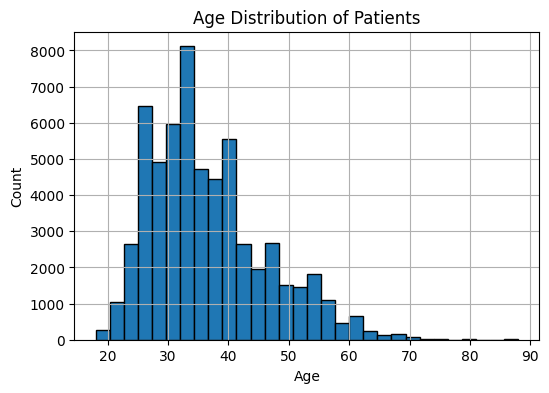

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_age_hist(df):
    plt.figure(figsize=(6,4))
    df['AGE'].hist(bins=30, edgecolor="black")
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.title("Age Distribution of Patients")
    plt.show()

_ = plot_age_hist(df)

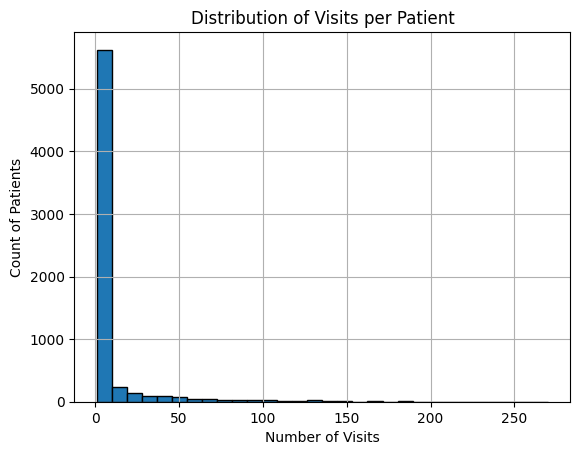

In [10]:
def patient_num_of_visit(df):
    visits_per_patient = df.groupby("PATIENT_NUM")["VISIT_DT"].count()
    visits_per_patient.hist(bins=30, edgecolor="black")
    plt.xlabel("Number of Visits")
    plt.ylabel("Count of Patients")
    plt.title("Distribution of Visits per Patient")
    plt.show()

patient_num_of_visit(df)

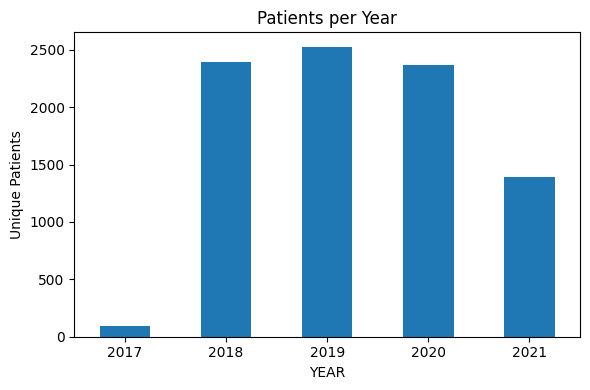

In [11]:
def patient_per_year(df):
    df['YEAR'] = pd.to_datetime(df['VISIT_DT']).dt.year
    visits_per_year = df.groupby('YEAR')["PATIENT_NUM"].nunique()
    
    visits_per_year.plot(kind="bar", figsize=(6,4))
    plt.ylabel("Unique Patients")
    plt.title("Patients per Year")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

patient_per_year(df)

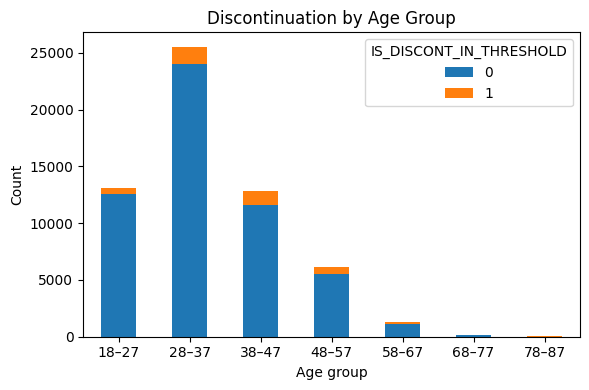

In [12]:
import math
def discont_by_age_grp(df, step=10):
    df = df.copy()
    mn = math.floor(df["AGE"].min())
    mx = math.ceil(df["AGE"].max())

    # integer-edged bins and clean string labels
    bins = np.arange(mn, mx + step, step)
    labels = [f"{bins[i]}–{bins[i+1]-1}" for i in range(len(bins) - 1)]

    df["AGE_GROUP"] = pd.cut(df["AGE"], bins=bins, include_lowest=True, labels=labels)

    ax = (df.groupby(["AGE_GROUP", "IS_DISCONT_IN_THRESHOLD"], observed=True)
            .size().unstack(fill_value=0)
            .plot(kind="bar", stacked=True, figsize=(6, 4)))

    ax.set_xlabel("Age group")
    ax.set_ylabel("Count")
    ax.set_title("Discontinuation by Age Group")
    ax.tick_params(axis="x", rotation=0)
    plt.tight_layout()
    plt.show()
discont_by_age_grp(df)

In [13]:
def plot_patient_timelines_with_age_gradient_v0(
    df,
    patient_col="PATIENT_NUM",
    x_col="CUMUL_DAYS_REF_THIS_PATIENT_MIN",
    y_col="AGE",
    discont_flag_col="IS_DISCONT_IN_THRESHOLD",
    discont_range=None,   # optional: (min_day, max_day) filter on each patient's LAST day
    threshold=11,         # color scale top (vmax). bottom is 0.
    show_points=True,
    line_width=0.8,
):
    """
    AGE vs per-patient cumulative days (discontinued patients only).
    Colors: custom red→orange→yellow→green (low=red, high=green).
    Colorbar fixed to 0..threshold (default 0..11).
    Also prints how many patients discontinued within 0..threshold days.
    Returns: (count_within, total_discontinued)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from matplotlib.cm import ScalarMappable

    # --- checks ---
    for c in [patient_col, x_col, y_col, discont_flag_col]:
        if c not in df.columns:
            raise KeyError(f"Missing column: {c}")

    # keep discontinued rows only
    d = df[df[discont_flag_col].astype(bool)][[patient_col, x_col, y_col]].dropna()
    if d.empty:
        print("No discontinued patients to plot.")
        return 0, 0

    # optional: restrict to patients whose LAST day is within a range
    if discont_range is not None:
        last_per_patient_all = d.groupby(patient_col)[x_col].max()
        keep_ids = last_per_patient_all[
            (last_per_patient_all >= discont_range[0]) & (last_per_patient_all < discont_range[1])
        ].index
        d = d[d[patient_col].isin(keep_ids)]
        if d.empty:
            print("No patients match the given discontinuation range.")
            return 0, 0

    # --- compute counts within 0..threshold days (by patient's last day) ---
    last_per_patient = d.groupby(patient_col)[x_col].max()
    total_discontinued = int(last_per_patient.size)
    count_within = int((last_per_patient <= float(threshold)).sum())
    pct = (100.0 * count_within / total_discontinued) if total_discontinued else 0.0
    print(f"Discontinued within 0–{int(threshold)} days: {count_within}/{total_discontinued} "
          f"patients ({pct:.1f}%).")

    # --- fixed color scale 0..threshold ---
    vmin, vmax = 0.0, float(threshold)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)   # clip values > threshold
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "ro_y_g", ["red", "orange", "yellow", "green"]
    )

    # --- plot ---
    fig, ax = plt.subplots(figsize=(10, 6))
    for pid, sub in d.sort_values([patient_col, x_col]).groupby(patient_col):
        x = sub[x_col].to_numpy()
        y = sub[y_col].to_numpy()
        if len(x) >= 2:
            for i in range(len(x) - 1):
                ax.plot([x[i], x[i+1]], [y[i], y[i+1]],
                        color=cmap(norm(x[i])), linewidth=line_width, alpha=0.85)
        if show_points:
            ax.scatter(x, y, c=cmap(norm(x)), s=30, edgecolors="k", linewidths=0.3, alpha=0.8)

    # colorbar 0..threshold (green at top, red at bottom)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=ax, label=f"{x_col} (red→green)")
    cb.set_ticks(range(int(vmin), int(vmax) + 1))

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    title = f"{y_col} vs {x_col} (discontinued only, scale 0–{int(threshold)})"
    if discont_range is not None:
        lo, hi = discont_range
        title += f" — last day in [{lo},{hi})"
    ax.set_title(title)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

    return count_within, total_discontinued


Discontinued within 0–11 days: 3313/3313 patients (100.0%).


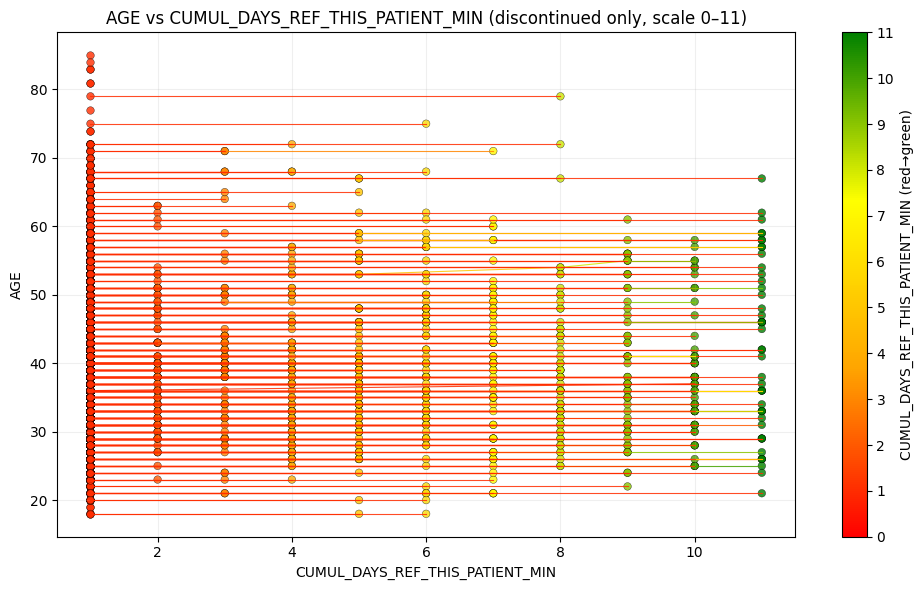

3313 of 3313 patients discontinued within 0–11 days.


In [14]:
count_within, total_discontinued = plot_patient_timelines_with_age_gradient_v0(df, threshold=11)
print(count_within, "of", total_discontinued, "patients discontinued within 0–11 days.")

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_discontinuation_bars_0_to_11(
    df,
    patient_col="PATIENT_NUM",
    cumul_col="CUMUL_DAYS_REF_THIS_PATIENT_MIN",
    max_day=11,
    verbose=1,
):
    """
    For each patient, take MAX(cumul_col); if that max == 0, treat it as 1.
    Plot bars for exact days 1..max_day labeled day1..day{max_day}, with counts above bars.
    """
    # checks
    for c in [patient_col, cumul_col]:
        if c not in df.columns:
            raise KeyError(f"Missing column: {c}")

    # per-patient max (coerce numeric first)
    d = df[[patient_col, cumul_col]].copy()
    d[cumul_col] = pd.to_numeric(d[cumul_col], errors="coerce")
    max_per_pt = d.groupby(patient_col, sort=False)[cumul_col].max()  # no skipna arg

    # mask 0 -> 1 at patient-level
    max_per_pt = max_per_pt.where(max_per_pt != 0, 1)

    # counts for exact days 1..max_day
    days = np.arange(1, max_day + 1)
    counts = np.array([(max_per_pt == k).sum() for k in days], dtype=int)

    # plot
    labels = [f"day{i}" for i in days]
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(days, counts)

    ax.set_xlim(0.5, max_day + 0.5)
    ax.set_xticks(days, labels)
    ax.set_xlabel("Discontinuation day (exact)")
    ymax = counts.max() if counts.size else 0
    ytick_max = max(500, ((ymax + 499) // 500) * 500) if ymax > 0 else 500
    ax.set_yticks(np.arange(0, ytick_max + 1, 500))
    ax.set_ylabel("Number of patients")
    ax.set_title(f"Patients with MAX discontinuation day = 1..{max_day}")
    ax.grid(axis="y", alpha=0.2)

    # numbers on top
    pad = max(1, 0.01 * (ymax if ymax else 1))
    for bar, v in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2.0,
                bar.get_height() + pad,
                str(int(v)),
                ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(", ".join(f"{lab}: {int(c)}" for lab, c in zip(labels, counts)))
        print(f"Total patients with MAX day in 1..{max_day}: {int(counts.sum())}")

    return pd.Series(counts, index=labels, name="count")


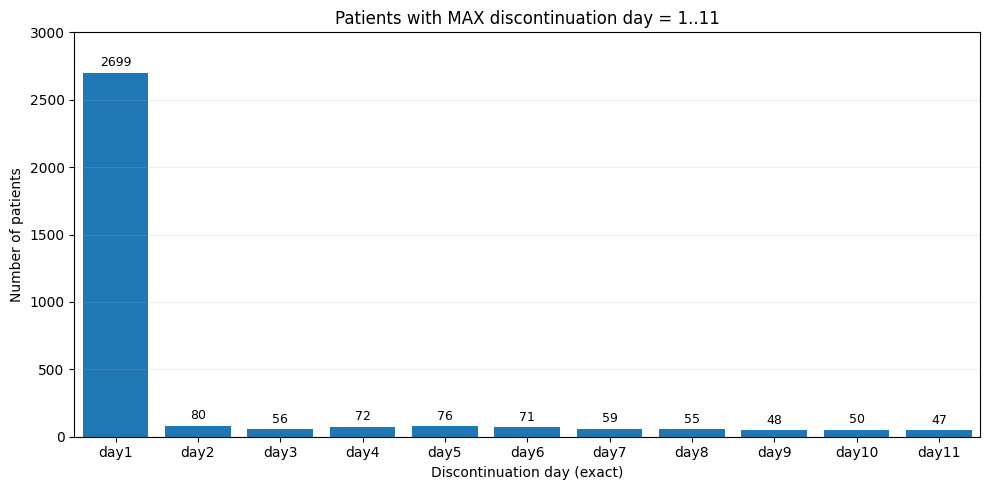

day1: 2699, day2: 80, day3: 56, day4: 72, day5: 76, day6: 71, day7: 59, day8: 55, day9: 48, day10: 50, day11: 47
Total patients with MAX day in 1..11: 3313


In [22]:
counts = plot_discontinuation_bars_0_to_11(
    df,
    patient_col="PATIENT_NUM",
    cumul_col="CUMUL_DAYS_REF_THIS_PATIENT_MIN",
    max_day=11,
    verbose=1,
)


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_discontinuation_by_unit_bins(
    df: pd.DataFrame,
    patient_col: str = "PATIENT_NUM",
    cumul_col: str = "CUMUL_DAYS_REF_THIS_PATIENT_MIN",
    max_edge: int = 11,          # makes bins: (0,1], (1,2], ..., (10,11]
    show_counts: bool = True
):
    """
    For each patient, compute DISCONTINUATION_DAY = max(cumul_col).
    Count patients whose discontinuation day falls in unit-width bins:
    (0,1], (1,2], ..., (max_edge-1, max_edge], and plot a bar chart.

    Returns a dataframe with counts per bin.
    """
    # 1) one row per patient with their discontinuation day
    last_day = (df.groupby(patient_col)[cumul_col]
                  .max()
                  .rename("discontinuation_day")
                  .reset_index())

    # 2) unit bins (right-closed -> includes the upper edge)
    edges  = np.arange(0, max_edge + 1, 1)            # 0..max_edge
    labels = [f"{i}-{i+1}" for i in range(0, max_edge)]
    last_day["bin"] = pd.cut(
        last_day["discontinuation_day"],
        bins=edges,
        right=True,              # (a,b]
        include_lowest=False,    # exclude 0 exactly from (0,1]
        labels=labels
    )

    # 3) counts per bin (keep all bins even if zero)
    counts = last_day["bin"].value_counts().sort_index()
    counts = counts.reindex(labels, fill_value=0)
    out = counts.rename("patients").rename_axis("bin").reset_index()

    # 4) plot
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(out["bin"].astype(str), out["patients"])
    ax.set_xlabel("Discontinuation day (unit bins)")
    ax.set_ylabel("Number of patients")
    ax.set_title("Patients by discontinuation-day bins")

    if show_counts:
        ymax = out["patients"].max() if len(out) else 0
        for bar, v in zip(bars, out["patients"].tolist()):
            ax.text(bar.get_x() + bar.get_width()/2.0,
                    bar.get_height() + max(1, 0.01*(ymax if ymax else 1)),
                    str(int(v)), ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()
    return out


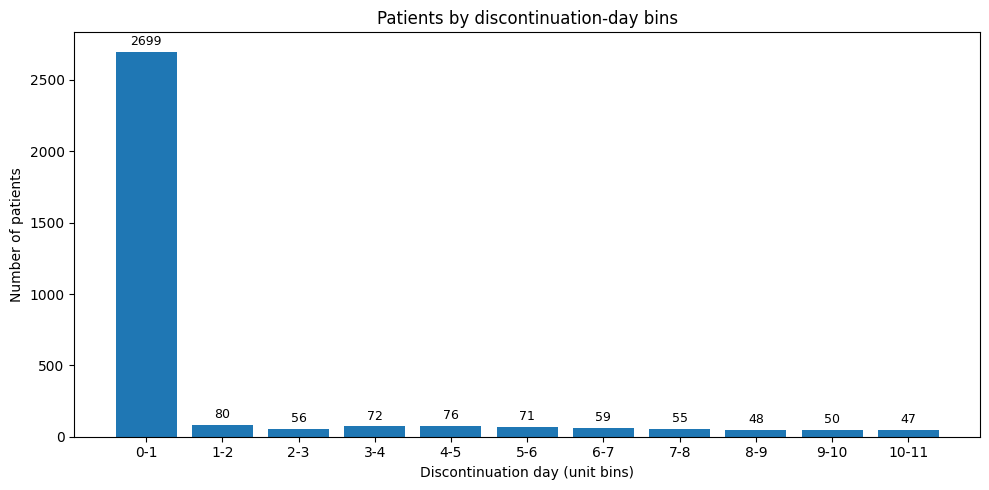

      bin  patients
0     0-1      2699
1     1-2        80
2     2-3        56
3     3-4        72
4     4-5        76
5     5-6        71
6     6-7        59
7     7-8        55
8     8-9        48
9    9-10        50
10  10-11        47


In [24]:
# df = pd.read_csv("COHORT_PRE_EPIC_DEID_cols_added.csv")

counts_df = plot_discontinuation_by_unit_bins(
    df_cols_added,
    patient_col="PATIENT_NUM",
    cumul_col="CUMUL_DAYS_REF_THIS_PATIENT_MIN",
    max_edge=11   # bins: 0–1, 1–2, …, 10–11
)

print(counts_df)


In [25]:
def plot_discontinued_vs_not_by_bin(
    df,
    patient_col="PATIENT_NUM",
    cumul_col="CUMUL_DAYS_REF_THIS_PATIENT_MIN",
    flag_col="IS_DISCONT_IN_THRESHOLD",
    bin_width=11,
):
    """
    For each (a,b] bin with width=bin_width starting at 0 (i.e., (0,11], (11,22], ...),
    plot two bars: discontinued vs not discontinued (patient-level).
    'Discontinued' is defined at the patient level as any row with flag_col == True.
    'last_day' is the per-patient max of cumul_col (ignoring NaNs).
    Patients with last_day == 0 are excluded from binning (by right-closed bins).
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import math

    # ---- Patient-level aggregates ----
    # last_day per patient
    d = df[[patient_col, cumul_col]].dropna()
    if d.empty:
        print("No rows with valid cumulative days.")
        return None

    last_day = (
        d.groupby(patient_col, as_index=False)[cumul_col]
         .max()
         .set_index(patient_col)[cumul_col]
    )

    # patient-level discontinued flag: True if patient has any True in flag_col
    disc_by_patient = (
        df[[patient_col, flag_col]]
        .dropna(subset=[flag_col])
        .groupby(patient_col)[flag_col]
        .max()
        .astype(bool)
        .reindex(last_day.index, fill_value=False)  # align to patients with a last_day
    )

    # ---- Build bins (right-closed) ----
    hi = float(bin_width * math.ceil(last_day.max() / bin_width))
    edges = np.arange(0.0, hi + bin_width, bin_width)  # 0, 11, 22, ...
    cats = pd.cut(last_day, bins=edges, right=True, include_lowest=False)  # (a,b]

    # Keep only patients that fall into one of the bins (excludes last_day==0)
    valid = cats.notna()
    if valid.sum() == 0:
        print("No patients fall into (0, ...] bins (all last_day == 0?).")
        return None

    bins = cats[valid]
    disc = disc_by_patient[valid]

    # ---- Count per bin x discontinued/not ----
    counts = (
        pd.DataFrame({"bin": bins, "discontinued": disc})
        .groupby(["bin", "discontinued"])
        .size()
        .unstack("discontinued", fill_value=0)
        .rename(columns={False: "not_discontinued", True: "discontinued"})
        .sort_index()
    )

    # Ensure both columns exist
    for col in ("discontinued", "not_discontinued"):
        if col not in counts.columns:
            counts[col] = 0
    counts = counts[["discontinued", "not_discontinued"]]

    # X labels like "(0, 11]"
    x_labels = [f"({int(iv.left)}, {int(iv.right)}]" for iv in counts.index]

    # ---- Plot grouped bars ----
    x = np.arange(len(counts))
    width = 0.42

    fig, ax = plt.subplots(figsize=(12, 5))
    bars_disc = ax.bar(x - width/2, counts["discontinued"].values, width, label="Discontinued")
    bars_not  = ax.bar(x + width/2, counts["not_discontinued"].values, width, label="Not discontinued")

    ax.set_xlabel("Discontinuation day bins (right-closed, (a,b])")
    ax.set_ylabel("Number of patients (last day in bin)")
    ax.set_title(f"Patients by last-day bin and status (bin_width={bin_width})")
    ax.set_xticks(x, x_labels, rotation=45, ha="right")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

    # ---- Annotate values on top of each bar ----
    def annotate(bars):
        for r in bars:
            h = r.get_height()
            ax.annotate(
                f"{int(h)}",
                xy=(r.get_x() + r.get_width()/2, h),
                xytext=(0, 3), textcoords="offset points",
                ha="center", va="bottom", fontsize=9
            )
    annotate(bars_disc)
    annotate(bars_not)

    # If everything is zero (unlikely), keep labels visible
    if counts.values.max() == 0:
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

    # Optional: print a small table for quick inspection
    print(counts.astype(int))

    return counts


/tmp/ipykernel_29657/2783827076.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["bin", "discontinued"])


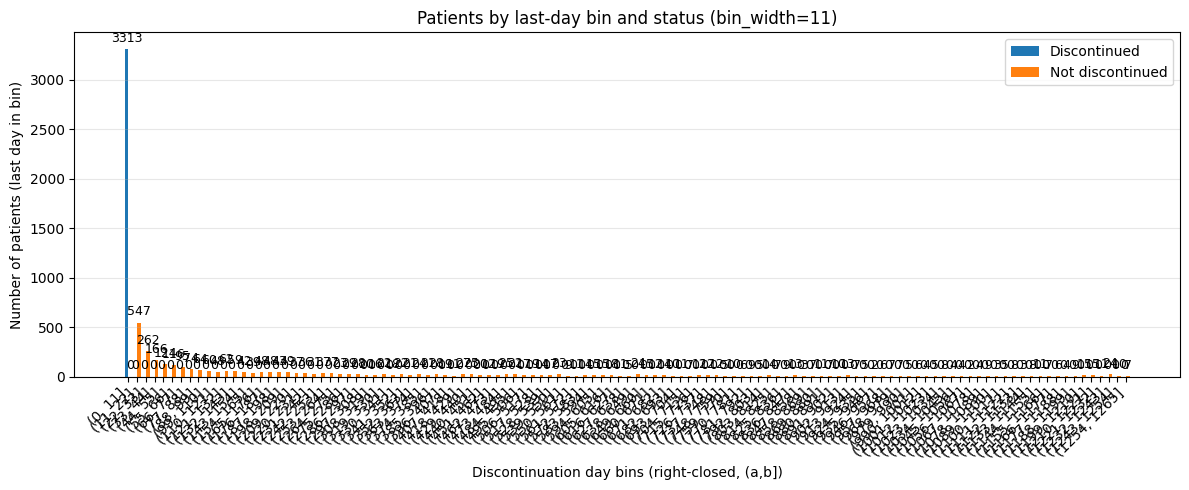

discontinued      discontinued  not_discontinued
bin                                             
(0.0, 11.0]               3313                 0
(11.0, 22.0]                 0               547
(22.0, 33.0]                 0               262
(33.0, 44.0]                 0               166
(44.0, 55.0]                 0               124
...                        ...               ...
(1210.0, 1221.0]             0                15
(1221.0, 1232.0]             0                11
(1232.0, 1243.0]             0                24
(1243.0, 1254.0]             0                10
(1254.0, 1265.0]             0                 7

[115 rows x 2 columns]


In [26]:
# _ = plot_discontinued_vs_not_by_bin(df_cols_added)          # bins (0,11], (11,22], ... up to max
_ = plot_discontinued_vs_not_by_bin(df, bin_width=11)  # if you want 14-day bins


In [30]:
def plot_discontinued_20_groups(
    df,
    patient_col="PATIENT_NUM",
    cumul_col="CUMUL_DAYS_REF_THIS_PATIENT_MIN",
    discont_flag_col=None,   # ignored
    bin_width=11,
    n_groups=20,
):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt

    # patient-level last day
    d = df[[patient_col, cumul_col]].dropna().copy()
    last_day = d.groupby(patient_col)[cumul_col].max()

    # build bins: (0,11], (11,22], ... up to n_groups
    edges = np.arange(0, (n_groups + 1) * bin_width, bin_width)
    cats = pd.cut(last_day, bins=edges, right=True, include_lowest=False)  # (a,b]
    counts = cats.value_counts(sort=False)

    x_labels = [f"({int(iv.left)}, {int(iv.right)}]" for iv in counts.index]
    y = counts.values

    plt.figure(figsize=(12, 5))
    bars = plt.bar(range(len(y)), y)  # use numeric x for easy annotation
    plt.xticks(range(len(y)), x_labels, rotation=45, ha="right")
    plt.xlabel("Discontinuation day bins (a,b]")
    plt.ylabel("Number of patients (last day)")
    plt.title(f"Patients by last-day bin (bin={bin_width}, groups={n_groups})")
    plt.grid(axis="y", alpha=0.3)

    # write value on top of each bar
    ymax = y.max() if len(y) else 0
    pad = max(1, 0.01 * (ymax if ymax else 1))
    for i, (bar, v) in enumerate(zip(bars, y)):
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            bar.get_height() + pad,
            f"{int(v)}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

    # also print to console
    for lbl, cnt in zip(x_labels, y):
        print(f"{lbl}: {int(cnt)}")

    return counts  # pandas Series indexed by Interval


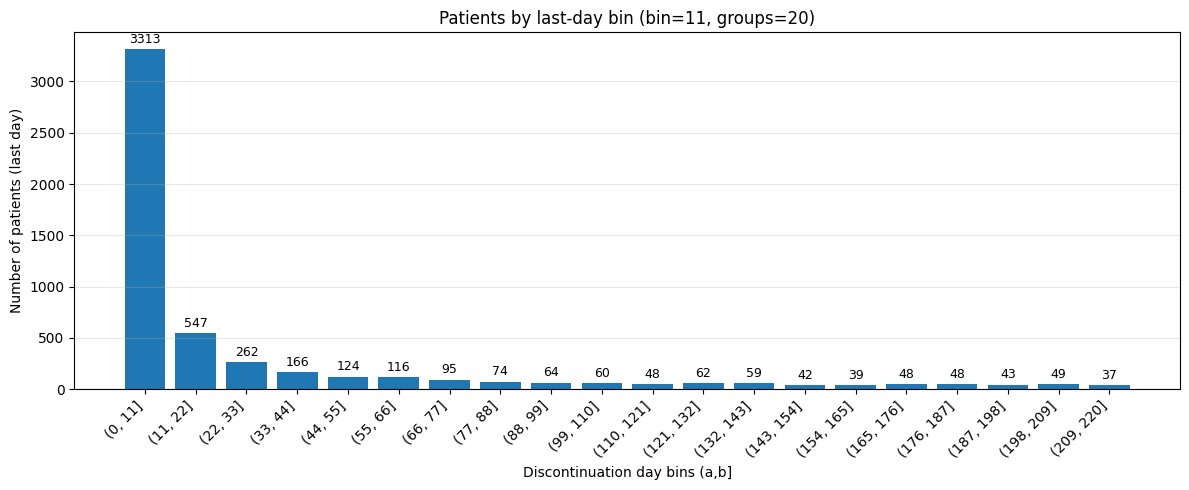

(0, 11]: 3313
(11, 22]: 547
(22, 33]: 262
(33, 44]: 166
(44, 55]: 124
(55, 66]: 116
(66, 77]: 95
(77, 88]: 74
(88, 99]: 64
(99, 110]: 60
(110, 121]: 48
(121, 132]: 62
(132, 143]: 59
(143, 154]: 42
(154, 165]: 39
(165, 176]: 48
(176, 187]: 48
(187, 198]: 43
(198, 209]: 49
(209, 220]: 37


In [33]:
# Exactly your spec: (0,11], (11,22], ... 20 groups
_ = plot_discontinued_20_groups(df, bin_width=11, n_groups=20)


In [34]:
def plot_discontinued_bins_to_max(
    df,
    patient_col="PATIENT_NUM",
    cumul_col="CUMUL_DAYS_REF_THIS_PATIENT_MIN",
    discont_flag_col=None,  # set to "IS_DISCONT_IN_THRESHOLD" if you really want to filter
    bin_width=11,
    start_at_zero=True,     # start bins at 0; set False to start at data min
    show_values=True,       # <— NEW: write number on top of each bar
    value_fmt="{:,.0f}",    # <— NEW: formatting for the labels
):
    """
    X-axis: day bins (a,b] like (0,11], (11,22], ... up to the max last day (auto).
    Y-axis: number of patients whose LAST day falls in each bin.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import math

    # Pick rows (optionally filter by a flag)
    if discont_flag_col is not None:
        d = df[df[discont_flag_col].astype(bool)][[patient_col, cumul_col]].dropna()
    else:
        d = df[[patient_col, cumul_col]].dropna()

    if d.empty:
        print("No patients found for plotting.")
        return None

    # Per-patient last (discontinuation) day
    last_day = d.groupby(patient_col)[cumul_col].max()

    # Bin edges from 0 (or min) up to ceil(max) by bin_width
    lo = 0.0 if start_at_zero else float(last_day.min() // bin_width * bin_width)
    hi = float(bin_width * math.ceil(last_day.max() / bin_width))
    edges = np.arange(lo, hi + bin_width, bin_width)  # inclusive of top edge

    # Right-closed bins: (a,b]
    cats = pd.cut(last_day, bins=edges, right=True, include_lowest=False)
    counts = cats.value_counts(sort=False)

    # Labels like "(0, 11]"
    x_labels = [f"({int(iv.left)}, {int(iv.right)}]" for iv in counts.index]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 5))
    bars = ax.bar(x_labels, counts.values)
    ax.set_xlabel("Discontinuation day bins (right-closed, (a,b])")
    ax.set_ylabel("Number of patients (last day in bin)")
    ax.set_title(f"Patients by last-day bin (bin_width={bin_width}, up to {int(hi)})")
    plt.xticks(rotation=45, ha="right")
    ax.grid(axis="y", alpha=0.3)

    # === NEW: add value labels on top of bars ===
    if show_values:
        # small vertical offset in points so text isn't flush with the bar
        for rect in bars:
            height = rect.get_height()
            ax.annotate(
                value_fmt.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=9,
            )

        # If all counts are zero, make sure labels are visible
        if counts.max() == 0:
            ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

    # Print counts too
    for lbl, cnt in zip(x_labels, counts.values):
        print(f"{lbl}: {int(cnt)}")
    print(f"\nTotal patients counted: {int(counts.sum())}")

    return counts


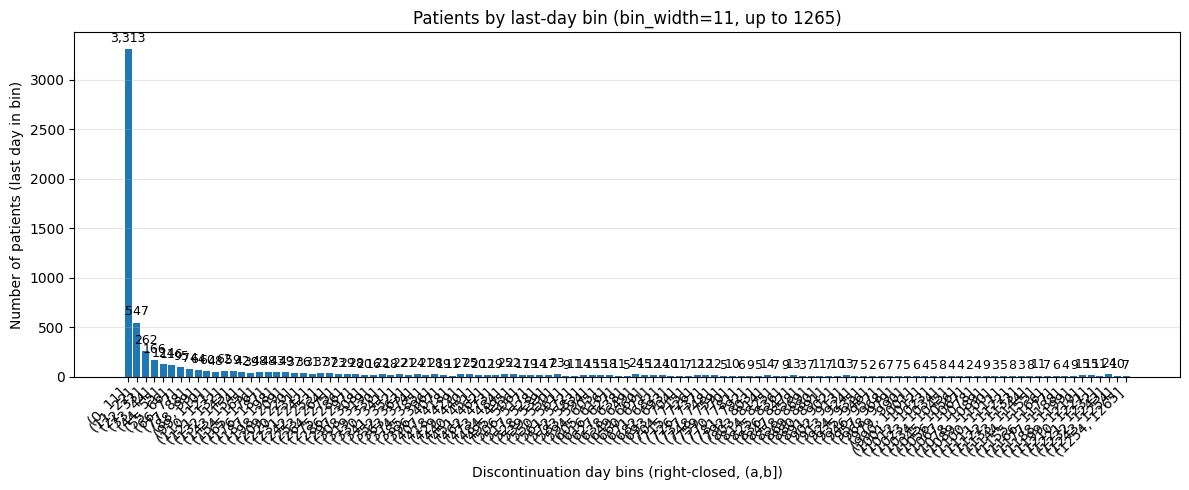

(0, 11]: 3313
(11, 22]: 547
(22, 33]: 262
(33, 44]: 166
(44, 55]: 124
(55, 66]: 116
(66, 77]: 95
(77, 88]: 74
(88, 99]: 64
(99, 110]: 60
(110, 121]: 48
(121, 132]: 62
(132, 143]: 59
(143, 154]: 42
(154, 165]: 39
(165, 176]: 48
(176, 187]: 48
(187, 198]: 43
(198, 209]: 49
(209, 220]: 37
(220, 231]: 36
(231, 242]: 31
(242, 253]: 37
(253, 264]: 37
(264, 275]: 23
(275, 286]: 29
(286, 297]: 28
(297, 308]: 20
(308, 319]: 16
(319, 330]: 22
(330, 341]: 18
(341, 352]: 22
(352, 363]: 21
(363, 374]: 24
(374, 385]: 21
(385, 396]: 28
(396, 407]: 19
(407, 418]: 11
(418, 429]: 27
(429, 440]: 25
(440, 451]: 20
(451, 462]: 12
(462, 473]: 19
(473, 484]: 25
(484, 495]: 22
(495, 506]: 17
(506, 517]: 19
(517, 528]: 14
(528, 539]: 17
(539, 550]: 23
(550, 561]: 9
(561, 572]: 11
(572, 583]: 14
(583, 594]: 15
(594, 605]: 15
(605, 616]: 18
(616, 627]: 11
(627, 638]: 5
(638, 649]: 24
(649, 660]: 15
(660, 671]: 12
(671, 682]: 14
(682, 693]: 10
(693, 704]: 11
(704, 715]: 7
(715, 726]: 12
(726, 737]: 12
(737, 748]:

In [36]:
# All patients, bins of width 11 up to the max
_ = plot_discontinued_bins_to_max(df_cols_added, bin_width=11)

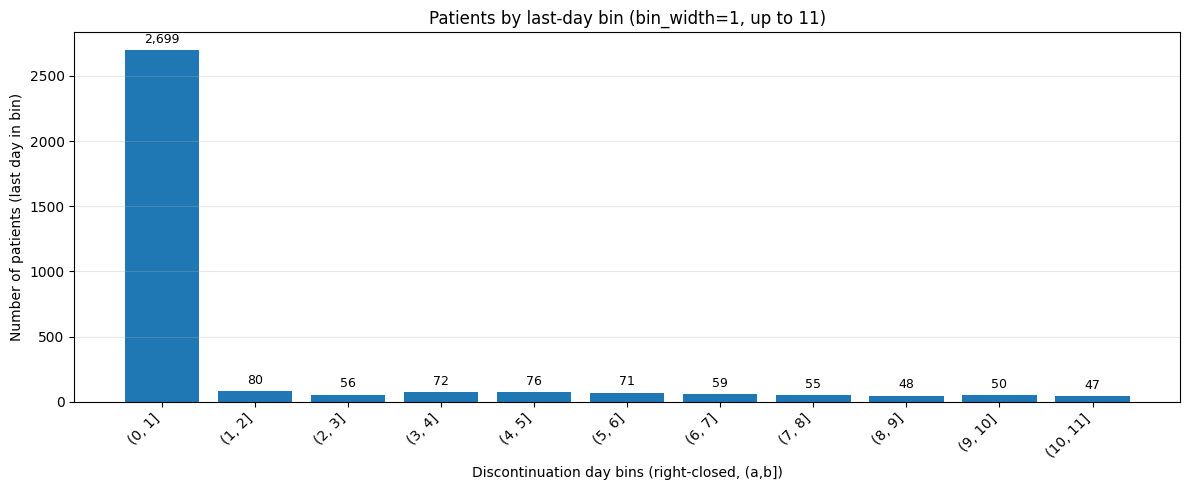

(0, 1]: 2699
(1, 2]: 80
(2, 3]: 56
(3, 4]: 72
(4, 5]: 76
(5, 6]: 71
(6, 7]: 59
(7, 8]: 55
(8, 9]: 48
(9, 10]: 50
(10, 11]: 47

Total patients counted: 3313


CUMUL_DAYS_REF_THIS_PATIENT_MIN
(0.0, 1.0]      2699
(1.0, 2.0]        80
(2.0, 3.0]        56
(3.0, 4.0]        72
(4.0, 5.0]        76
(5.0, 6.0]        71
(6.0, 7.0]        59
(7.0, 8.0]        55
(8.0, 9.0]        48
(9.0, 10.0]       50
(10.0, 11.0]      47
Name: count, dtype: int64

In [37]:
# If you truly want to keep your flag filter:
plot_discontinued_bins_to_max(df_cols_added, discont_flag_col="IS_DISCONT_IN_THRESHOLD", bin_width=1)


In [38]:
def reconciliation_report_simple(
    df,
    patient_col="PATIENT_NUM",
    cumul_col="CUMUL_DAYS_REF_THIS_PATIENT_MIN",
    flag_col="IS_DISCONT_IN_THRESHOLD",
    bin_range=None,       # set like (0, 11) to limit to discontinued with last_day in (0,11]
    include_ids=False,    # return the patient ids used in the report
):
    import pandas as pd

    # Per-patient last day (from valid cumul rows)
    d = df[[patient_col, cumul_col]].dropna()
    last_day = d.groupby(patient_col, as_index=False)[cumul_col].max().set_index(patient_col)[cumul_col]

    # Sets for convenience
    all_patients      = set(df[patient_col].unique())
    discontinued_set  = set(df.loc[df[flag_col].astype(bool), patient_col].unique())

    # Optional bin filter: restrict to discontinued AND last_day in (lo, hi]
    if bin_range is not None:
        lo, hi = bin_range
        in_bin = {p for p, ld in last_day.items() if (ld > lo) and (ld <= hi)}
        subset_patients = discontinued_set & in_bin
    else:
        subset_patients = all_patients

    # Subset DF rows for row count
    df_sub = df[df[patient_col].isin(subset_patients)]

    # Metrics within the chosen subset
    total_rows = int(len(df_sub))
    total_unique_patients = int(len(subset_patients))
    total_patients_discontinued = int(len(discontinued_set & subset_patients))
    total_patients_not_discontinued = int(total_unique_patients - total_patients_discontinued)

    # Last-day metrics computed from valid cumul rows only (like your originals)
    ld_sub = last_day.reindex(subset_patients).dropna()
    last_day_eq_0 = int((ld_sub == 0).sum())
    last_day_ne_0 = int((ld_sub != 0).sum())

    out = {
        "total_rows": total_rows,
        "total_unique_patients": total_unique_patients,
        "total_patients_discontinued": total_patients_discontinued,
        "total_patients_not_discontinued": total_patients_not_discontinued,
        "total_patients_last_day_eq_0": last_day_eq_0,
        "total_patients_last_day_ne_0": last_day_ne_0,
    }
    if include_ids:
        out["patient_ids_used"] = subset_patients
    return out


In [39]:
# Overall (no bin filter)
report_all = reconciliation_report_simple(df_cols_added)

# Only discontinued with last_day in (0, 11]
report_0_11 = reconciliation_report_simple(df_cols_added, bin_range=(0, 11))

print(report_all)
print(report_0_11)


{'total_rows': 59091, 'total_unique_patients': 6566, 'total_patients_discontinued': 3313, 'total_patients_not_discontinued': 3253, 'total_patients_last_day_eq_0': 0, 'total_patients_last_day_ne_0': 6566}
{'total_rows': 4134, 'total_unique_patients': 3313, 'total_patients_discontinued': 3313, 'total_patients_not_discontinued': 0, 'total_patients_last_day_eq_0': 0, 'total_patients_last_day_ne_0': 3313}


### 3 Save data

In [25]:
# csv_path = helper.write_csv_file("op/hints6_public_filtered_v1_cleaned_encoded.csv", df_cleaned_encoded1_encoded2, verbose = 1)

Saved: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/hints6_public_filtered_v1_cleaned_encoded.csv
data shape: (4865, 27)
